In [1]:
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
#Reading in necessary datasets

#Dataset with match statistics and labels
data_classes=pd.read_csv('/content/drive/MyDrive/MATH 642 Final Project/Data/full_dataset_labeled.csv')
data_classes=data_classes.drop(columns=['Unnamed: 0'])

#Dataset with physical characteristics and labels
phys_chars_classes=pd.read_csv('/content/drive/MyDrive/MATH 642 Final Project/Data/physical_chars_dataset.csv')
phys_chars_classes=phys_chars_classes.drop(columns=['Unnamed: 0'])

In [21]:
#Performing train test split for a random forest model that will classify players into one of four groups based on their statistics
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data_classes.drop(columns=['class_rd','Player_Name']).to_numpy(), data_classes['class_rd'].to_numpy(), test_size=0.25,random_state=1)

In [6]:
#Tuning non PCA random forest
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
params={'n_estimators':np.arange(1,100,20),'max_depth':[1,3,5,9,15,20,30],'min_samples_leaf': [1, 2, 4],'min_samples_split': [2, 5, 10]}
grid=GridSearchCV(RandomForestClassifier(), params, refit = True, verbose = 1)
grid.fit(X_train,Y_train)
print(grid.best_params_)
print(grid.best_estimator_)


Fitting 5 folds for each of 315 candidates, totalling 1575 fits
{'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 21}
RandomForestClassifier(max_depth=20, min_samples_leaf=4, n_estimators=21)


In [7]:
#Getting prediction for this model on separate test set
print(grid.score(X_test,Y_test))
grid_predictions = grid.predict(X_test)

0.5671641791044776


In [22]:
#Scaling data before PCA
from sklearn.preprocessing import StandardScaler
scaler1=StandardScaler()
scaled_data_classes=scaler1.fit_transform(data_classes.drop(columns=['Player_Name','class_rd']))

from sklearn.decomposition import PCA
#Finding components that preserve 82% of the variance in the original dataset
pca=PCA(.82)

#Projecting the data onto these components
PCA_Mat=pca.fit_transform(scaled_data_classes)

#Creating train test split
X_train_pca,X_test_pca,Y_train_pca,Y_test_pca=train_test_split(PCA_Mat, data_classes['class_rd'].to_numpy(), test_size=0.25,random_state=1)

In [23]:
#Creating new scaled training and test sets without using PCA
X_train_sc,X_test_sc,Y_train_sc,Y_test_sc=train_test_split(scaled_data_classes, data_classes['class_rd'].to_numpy(), test_size=0.25,random_state=20)

In [24]:
#Fitting and Tuning SVM
params1={'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['linear','poly','rbf']}
grid1=GridSearchCV(SVC(), params1, refit = True, verbose = 1)
grid1.fit(X_train_sc, Y_train_sc)
print(grid1.best_params_)
print(grid1.best_estimator_)
print(grid1.score(X_test_sc,Y_test_sc))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.0001)
0.5522388059701493


In [ ]:
#KNN for PCA dataset
#Since KNN performs poorly in high dimensional spaces, we use KNN with the 5 feature dataset that was created using Principle Component Analysis
from sklearn.neighbors import KNeighborsClassifier
ks=np.arange(1,100)

#Creating dictionary for GridSearchCV
params_knn1=dict(n_neighbors=ks)

#Creating gridsearchCV object
knn_grid2=GridSearchCV(KNeighborsClassifier(), params_knn1, scoring='accuracy', refit=True,verbose=1)

#Fitting
knn_grid2.fit(X_train_pca, Y_train_pca)
print(knn_grid2.best_params_)
print(knn_grid2.best_estimator_)

#Scoring
print(knn_grid2.score(X_test_pca,Y_test_pca))
knn_grid2_predictions = knn_grid2.predict(X_test_pca)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
{'n_neighbors': 23}
KNeighborsClassifier(n_neighbors=23)
0.582089552238806


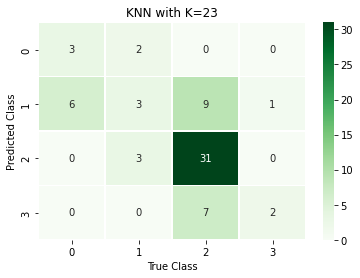

In [ ]:
#Creating nice heatmap
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
ax = sns.heatmap(confusion_matrix(Y_test_pca,knn_grid2.predict(X_test_pca)), linewidth=0.5,cmap='Greens',annot=True)
ax.set_xlabel('True Class')
ax.set_ylabel('Predicted Class')
ax.set_title('KNN with K=23')
plt.show()

In [25]:
#One hot encoding targets so they can be used with a simple neural network
import tensorflow as tf

#Preparing targets to be one hot encoded

Y_test_nn=Y_test_sc-1
Y_train_nn=Y_train_sc-1

#One hot encoding targets
Y_test_nn=tf.one_hot(Y_test_nn,depth=4)
Y_train_nn=tf.one_hot(Y_train_nn,depth=4)

In [26]:
#Training a small neural network using cross entropy loss and softmax activation functions
from tensorflow import keras
from keras.layers import Activation,Dense,Dropout

#One hot encoding targets

model=keras.Sequential()
model.add(Dense(10,input_shape=(14,),activation='relu'))
model.add(Dropout(.4))
model.add(Dense(7,activation='relu'))
model.add(Dense(4,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history=model.fit(X_train_sc,Y_train_nn,batch_size=20,epochs=100,validation_data=(X_test_sc,Y_test_nn),verbose=0)
model.evaluate(X_test_sc,Y_test_nn)

3/3 [==============================] - 0s 4ms/step - loss: 0.9978 - accuracy: 0.5075


[0.9977807402610779, 0.5074626803398132]

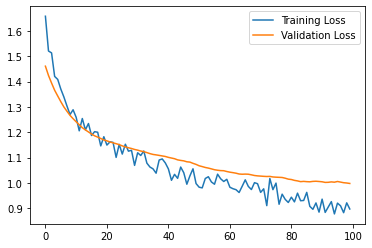

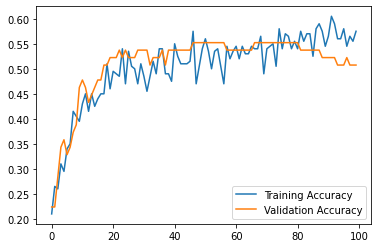

In [31]:
#Visualizing results
import matplotlib.pyplot as plt
plt.plot(range(0,100),history.history['loss'],label='Training Loss')
plt.plot(range(0,100),history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()
plt.plot(range(0,100),history.history['accuracy'],label='Training Accuracy')
plt.plot(range(0,100),history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

#Below, we can see that this small neural network does train, but isn't training fast enough or well enough to get reasonable predictions. This is
#likely because we just don't have enough observations to train a neural network effectively (we are only training on about 300)

In [32]:
#Predicting player class from physical characteristics (height and weight) in the multiclass setting proved to be difficult. To save space, these models
#have been cut from the document and we will simplify the problem to binary classification

In [34]:
#Creating a new column in the dataframe for binary classification labels
#Creating function to apply to rows to group classes 1 and 2 together and classes 3 and 4 together
def binary(row):
  if row==1 or row==2:
    row=1
  else:
    row=0
  return row
  
#Applying function to rows to create a new column
phys_chars_classes['bin_class']=phys_chars_classes['class_rd'].apply(binary)

In [36]:
#Creating train test split using new labels
X_train_nby,X_test_nby,Y_train_nby,Y_test_nby=train_test_split(phys_chars_classes[['height_inches','weight_lbs']].to_numpy(),phys_chars_classes['bin_class'].to_numpy(),test_size=.25,random_state=10)
#Creating scaled train test split using new labels without birth year
scaler2=StandardScaler()
scaled_nby=scaler2.fit_transform(phys_chars_classes[['height_inches','weight_lbs']].to_numpy())
X_train_nby_sc,X_test_nby_sc,Y_train_nby_sc,Y_test_nby_sc=train_test_split(scaled_nby,phys_chars_classes['bin_class'].to_numpy(),test_size=.25,random_state=10)

In [37]:
#Finding best params for binary RF model
from sklearn.model_selection import GridSearchCV
params={'n_estimators':np.arange(10,300,30),'max_depth':[3,5,9,15,20,30]}
grid=GridSearchCV(RandomForestClassifier(), params, refit = True, verbose = 1)
grid.fit(X_train_nby,Y_train_nby)
print(grid.best_params_)
print(grid.best_estimator_)

print(grid.score(X_test_nby,Y_test_nby))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'max_depth': 3, 'n_estimators': 40}
RandomForestClassifier(max_depth=3, n_estimators=40)
0.6111111111111112


In [38]:
#Fitting a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg1=LogisticRegression()
logreg1.fit(X_train_nby,Y_train_nby)
preds=logreg1.predict(X_test_nby)
print(logreg1.score(X_test_nby,Y_test_nby))

0.7037037037037037


In [39]:
#Tuning the SVM
from sklearn.model_selection import GridSearchCV
params={'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['linear','poly','rbf']}
grid=GridSearchCV(SVC(), params, refit = True, verbose = 1)
grid.fit(X_train_nby_sc, Y_train_nby_sc)
print(grid.best_params_)
print(grid.best_estimator_)

#grid_preds = grid.predict(X_test_bin_sc)
print(grid.score(X_test_nby_sc,Y_test_nby_sc))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
SVC(C=0.1, gamma=1, kernel='linear')
0.7037037037037037


In [40]:
#Neural network for binary classifier
#Preparing targets to be one hot encoded

# Y_test_nn_bin_sc=Y_test_bin_sc-1
# Y_train_nn_bin_sc=Y_train_bin_sc-1

# #One hot encoding targets
# Y_test_nn_bin_sc=tf.one_hot(Y_test_nn_bin_sc,depth=1)
# Y_train_nn_bin_sc=tf.one_hot(Y_train_nn_bin_sc,depth=1)

#Creating model
model=keras.Sequential()
model.add(Dense(10,input_shape=(2,),activation='relu'))
model.add(Dropout(.4))
model.add(Dense(7,activation='relu'))
model.add(Dropout(.4))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[keras.metrics.BinaryAccuracy(threshold=.5)])

history=model.fit(X_train_nby_sc,Y_train_nby_sc,batch_size=15,epochs=200,validation_data=(X_test_nby_sc,Y_test_nby_sc),verbose=0)
print(model.evaluate(X_test_nby_sc,Y_test_nby_sc))

2/2 [==============================] - 0s 7ms/step - loss: 0.6106 - binary_accuracy: 0.7037
[0.6106334328651428, 0.7037037014961243]


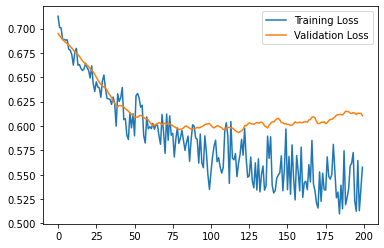

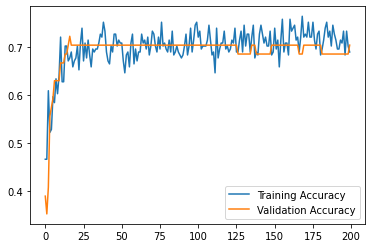

In [43]:
#Visualizing results
import matplotlib.pyplot as plt
plt.plot(range(0,200),history.history['loss'],label='Training Loss')
plt.plot(range(0,200),history.history['val_loss'],label='Validation Loss')
plt.legend()
plt.show()
plt.plot(range(0,200),history.history['binary_accuracy'],label='Training Accuracy')
plt.plot(range(0,200),history.history['val_binary_accuracy'],label='Validation Accuracy')
plt.legend()
plt.show()

#Here, we can see that we were able to lower both the training and validaiton loss significantly more than in the multiclass setting

In [46]:
#Tuning the KNN
#Creating a range of ks to try
ks=np.arange(1,100,1)

#Creating dictionary for GridSearchCV
params_knn=dict(n_neighbors=ks)

#Creating gridsearchCV object
knn_grid=GridSearchCV(KNeighborsClassifier(), params_knn, scoring='accuracy', refit=True,verbose=1)

#Fitting
knn_grid.fit(X_train_nby_sc, Y_train_nby_sc)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

#Scoring
print(knn_grid.score(X_test_nby_sc,Y_test_nby_sc))

Fitting 5 folds for each of 99 candidates, totalling 495 fits
{'n_neighbors': 23}
KNeighborsClassifier(n_neighbors=23)
0.6666666666666666


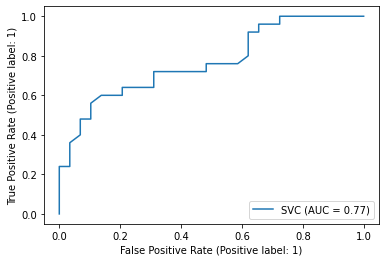

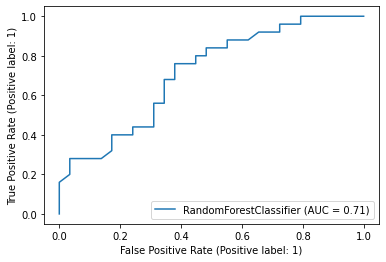

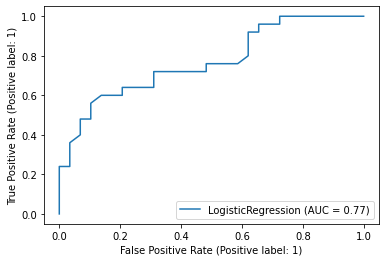

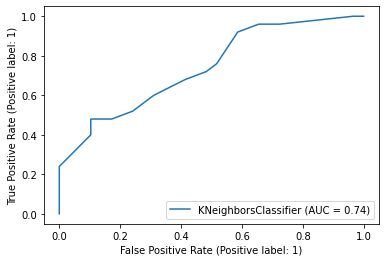

In [53]:
#Creating ROC Curve for SVM, Logistic Regression, Random Forest, maybe KNN?
from sklearn.metrics import RocCurveDisplay

#Creating best SVM from tuning
bestsvm=SVC(C=.1,gamma=.1,kernel='linear')
bestsvm.fit(X_train_nby_sc,Y_train_nby_sc)

#Creating best RF from tuning
bestRF=RandomForestClassifier(n_estimators=302)
bestRF.fit(X_train_nby,Y_train_nby)

#Logistic Regression Model was already created earlier

#Creating best KNN from tuning
best_knn=KNeighborsClassifier(n_neighbors=23)
best_knn.fit(X_train_nby_sc,Y_train_nby_sc)

#Wrapping ANN so ROC curve can be generated


#Creating ROC Curve objects for plotting later
svc_disp=RocCurveDisplay.from_estimator(bestsvm,X_test_nby_sc,Y_test_nby_sc)
rf_disp=RocCurveDisplay.from_estimator(bestRF,X_test_nby,Y_test_nby)
log_disp=RocCurveDisplay.from_estimator(logreg1,X_test_nby,Y_test_nby)
knn_disp=RocCurveDisplay.from_estimator(best_knn,X_test_nby_sc,Y_test_nby_sc)

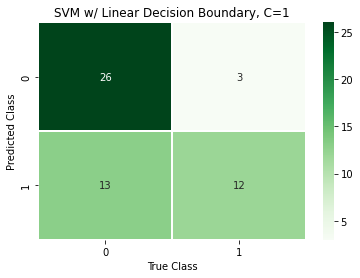

In [52]:
#Creating nice heatmap for best scoring model (SVM)
ax = sns.heatmap(confusion_matrix(Y_test_nby_sc,bestsvm.predict(X_test_nby_sc,)), linewidth=0.5,cmap='Greens',annot=True)
ax.set_xlabel('True Class')
ax.set_ylabel('Predicted Class')
ax.set_title('SVM w/ Linear Decision Boundary, C=1')
plt.show()

In [54]:
#Creating Roc Curve for ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_keras=model.predict(X_test_nby_sc).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test_nby_sc, y_pred_keras)
auc_keras=auc(fpr_keras, tpr_keras)

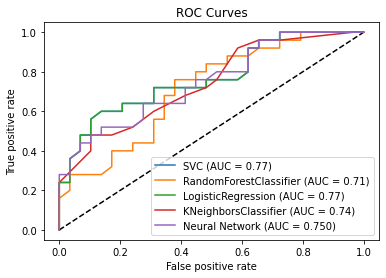

In [55]:
#Plotting ROC Curves
ax=plt.axes()
svc_disp.plot(ax)
rf_disp.plot(ax)
log_disp.plot(ax)
knn_disp.plot(ax)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Neural Network (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()